In [18]:
install.packages("DescTools")

Installing package into ‘/home/dcs01/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘rootSolve’, ‘e1071’, ‘lmom’, ‘cellranger’, ‘progress’, ‘hms’, ‘vroom’, ‘tzdb’, ‘forcats’, ‘mvtnorm’, ‘expm’, ‘Exact’, ‘gld’, ‘data.table’, ‘readxl’, ‘readr’, ‘haven’, ‘httr’


Warning message in download.file(urls, destfiles, "libcurl", mode = "wb", ...):
“URL 'https://cran.r-project.org/src/contrib/vroom_1.6.7.tar.gz': Timeout of 60 seconds was reached”
Warning message in download.file(urls, destfiles, "libcurl", mode = "wb", ...):
“URL 'https://cran.r-project.org/src/contrib/tzdb_0.5.0.tar.gz': Timeout of 60 seconds was reached”
Warning message in download.file(urls, destfiles, "libcurl", mode = "wb", ...):
“URL 'https://cran.r-project.org/src/contrib/forcats_1.0.1.tar.gz': Timeout of 60 seconds was reached”
Warning message in download.file(urls, destfiles, "libcurl", mode = "wb", ...):
“URL 'https://cran.r-project.org/src/contrib/mvtnorm_1.3-3

In [19]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
library(gridExtra)
library(tibble)
library(grid)
library(DescTools)
library(rcompanion)
library(tidyverse)

ERROR: Error in library(DescTools): there is no package called ‘DescTools’


In [11]:
source("forecast_research/finance/markets_functions.R")

In [14]:
load_all("forecast_research/vendor/hmmTMB")

ℹ Loading hmmTMB
ℹ Re-compiling hmmTMB (debug build)



── R CMD INSTALL ───────────────────────────────────────────────────────────────
* installing *source* package ‘hmmTMB’ ...
** this is package ‘hmmTMB’ version ‘1.1.0’
** using staged installation
rm -rf *o
** libs
/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v4/Compiler/gcccore/r/4.5.0/lib64/R/bin/Rscript --vanilla -e "invisible(TMB::compile('hmmTMB.cpp', safebounds = FALSE, safeunload = FALSE))"
Note: Using Makevars in /tmp/Rtmp3ztVf9/file32ace62f2fa7b0 
using C++ compiler: ‘g++ (Gentoo 12.3.1_p20230526 p2) 12.3.1 20230526’
make[1]: Entering directory '/project/6004619/dcs01/forecast_research/vendor/hmmTMB/src'
g++ -std=gnu++17 -I"/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v4/Compiler/gcccore/r/4.5.0/lib64/R/include" -DNDEBUG -I"/home/dcs01/R/x86_64-pc-linux-gnu-library/4.5/TMB/include" -I"/home/dcs01/R/x86_64-pc-linux-gnu-library/4.5/RcppEigen/include"   -DTMB_EIGEN_DISABLE_WARNINGS   -DTMB_LIB_INIT=R_init_hmmTMB  -DCPPAD_FRAMEWORK -I'/home/dcs01/R/x8

Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: TMB



Warning message:
“CL=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“GC=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“HG=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_Care_Index

Warning message:
“Setting row names on a tibble is deprecated.”


ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't select columns that don't exist.
[31m✖[39m Column `USD_to_CAD` doesn't exist.


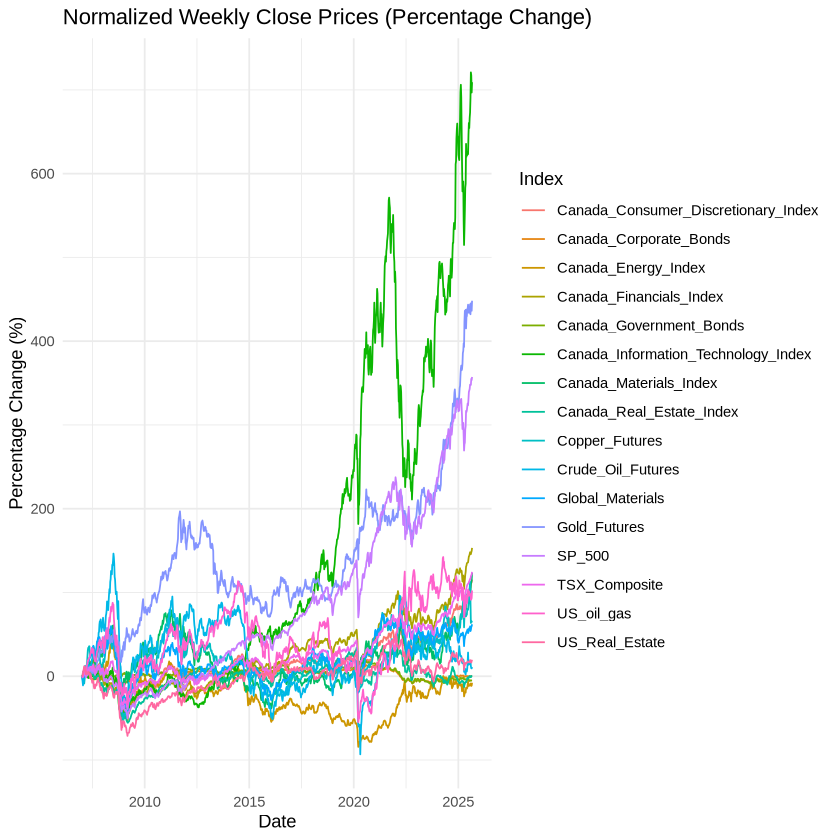

In [20]:
close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures,
    USD_to_CAD, Canada_Corporate_Bonds,
    Canada_Government_Bonds, US_oil_gas, Global_Materials,
    US_Real_Estate, SP_500,
  )

close_data_log <- ln_transform(close_data)

# Reshape data for ggplot
close_data_long <- close_data %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100)

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()